In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, TensorDataset, DataLoader, Subset
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torchvision.transforms as T


import torch.nn.functional as F
from torchvision import datasets, transforms


In [2]:
repo_root = Path().resolve().parents[0]   # parent of "notebooks"
sys.path.insert(0, str(repo_root / "src"))

from fisher_information.fim import FisherInformationMatrix
from models.image_classification_models import *
from models.train_test import *
from prunning_methods.LTH import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def build_loaders(data_dir: str, batch_size: int, device: torch.device, 
                  fim_size: int = 5000, seed: int = 42):
# CIFAR-10 stats
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    
    
    train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
    ])
    
    
    test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
    ])
    
    
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_tf)
    test_set = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_tf)

    num_classes = 10
    assert fim_size % num_classes == 0, \
        f"fim_size ({fim_size}) must be divisible by num_classes ({num_classes})"

    per_class = fim_size // num_classes

    targets = torch.tensor(train_set.targets)  # shape: [50000]
    g = torch.Generator().manual_seed(seed)
    
    indices_per_class = []
    for c in range(num_classes):
        class_idx = torch.nonzero(targets == c).view(-1)  # indices of samples of class c
        # shuffle indices for this class
        perm = class_idx[torch.randperm(len(class_idx), generator=g)]
        # take per_class samples
        indices_per_class.append(perm[:per_class])

    # concatenate all class indices and shuffle globally
    balanced_indices = torch.cat(indices_per_class)
    balanced_indices = balanced_indices[torch.randperm(len(balanced_indices), generator=g)]

    fim_subset = Subset(train_set, balanced_indices.tolist())
    
    train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
    )

    fim_loader = DataLoader(
    fim_subset,
    batch_size=1,
    shuffle=True
    )
    
    test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
    )
    
    return train_loader, fim_loader, test_loader

In [4]:
train_loader, fim_loader, test_loader = build_loaders('./data', 2048, device)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(fim_loader)

5000

In [15]:
model = torchvision.models.densenet121(num_classes=10)
for name, param in model.named_parameters():
    print(name, param.numel())

features.conv0.weight 9408
features.norm0.weight 64
features.norm0.bias 64
features.denseblock1.denselayer1.norm1.weight 64
features.denseblock1.denselayer1.norm1.bias 64
features.denseblock1.denselayer1.conv1.weight 8192
features.denseblock1.denselayer1.norm2.weight 128
features.denseblock1.denselayer1.norm2.bias 128
features.denseblock1.denselayer1.conv2.weight 36864
features.denseblock1.denselayer2.norm1.weight 96
features.denseblock1.denselayer2.norm1.bias 96
features.denseblock1.denselayer2.conv1.weight 12288
features.denseblock1.denselayer2.norm2.weight 128
features.denseblock1.denselayer2.norm2.bias 128
features.denseblock1.denselayer2.conv2.weight 36864
features.denseblock1.denselayer3.norm1.weight 128
features.denseblock1.denselayer3.norm1.bias 128
features.denseblock1.denselayer3.conv1.weight 16384
features.denseblock1.denselayer3.norm2.weight 128
features.denseblock1.denselayer3.norm2.bias 128
features.denseblock1.denselayer3.conv2.weight 36864
features.denseblock1.denselaye

In [7]:
def vgg16_cifar(num_classes: int = 10) -> nn.Module:
    model = torchvision.models.vgg16(num_classes=num_classes)
    # Replace the 7x7 stride-2 conv + maxpool with a 3x3 stride-1 conv and no pool
    #model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    #model.maxpool = nn.Identity()
    return model
#print(f"vgg16 tem {sum([p.numel() for p in vgg16_cifar().parameters()])} parametros")

In [16]:
fim_args = {"complete_fim": False, 
            "layers":  ['features.denseblock1.denselayer1.conv2.weight', "features.denseblock1.denselayer2.conv2.weight"],#'features.1.0.block.0.weight'],
            "mask":  None, 
            "sampling_type":  'x_skip_y', 
            "sampling_frequency":  (9,81)
            }


LTH_args = {"model": torchvision.models.densenet121(num_classes=10).to(device), 
            "criterion": nn.CrossEntropyLoss(), 
            "train_loader": train_loader, 
            "test_loader": test_loader, 
            "fim_loader": fim_loader, 
            "fim_args": fim_args, 
            "lr" : 1e-3,
            "n_iterations":10, 
            "n_epochs":100, 
            "prunning_percentage":0.1, 
            "no_prunning_layers":None, 
            "verbose":True,
            "print_freq":25, 
            "use_scheduler":False, 
            "save_path":None
            }
           

In [17]:
output_dict = train_LTH(**LTH_args)

LTH Iteration 1/10
Epoch 1/100- Loss: 1.4820319414138794
Epoch 26/100- Loss: 0.3618726134300232
Epoch 51/100- Loss: 0.19372060894966125
Epoch 76/100- Loss: 0.08085308223962784
Test Accuracy after iteration 1: 80.48%
LTH Iteration 2/10
Epoch 1/100- Loss: 2.0292553901672363
Epoch 26/100- Loss: 0.6465609073638916
Epoch 51/100- Loss: 0.42650333046913147
Epoch 76/100- Loss: 0.2480526566505432
Test Accuracy after iteration 2: 78.05%
LTH Iteration 3/10
Epoch 1/100- Loss: 1.8996621370315552


KeyboardInterrupt: 

In [11]:
for i in range(len(output_dict['fim_list'])):
    print(output_dict['fim_list'][i].fim['features.0.0.weight'].shape, output_dict['fim_list'][i].logdet_ratio)

torch.Size([4608, 4608]) {'features.0.0.weight': 24418.9951171875}
torch.Size([4608, 4608]) {'features.0.0.weight': 21831.6298828125}
torch.Size([4608, 4608]) {'features.0.0.weight': 19252.013671875}
torch.Size([4608, 4608]) {'features.0.0.weight': 16849.818359375}
torch.Size([4608, 4608]) {'features.0.0.weight': 14132.216796875}
torch.Size([4608, 4608]) {'features.0.0.weight': 11426.46484375}
torch.Size([4608, 4608]) {'features.0.0.weight': 8560.58984375}
torch.Size([4608, 4608]) {'features.0.0.weight': 5659.974609375}
torch.Size([4608, 4608]) {'features.0.0.weight': 2004.7578125}
torch.Size([4608, 4608]) {'features.0.0.weight': 498.0703125}


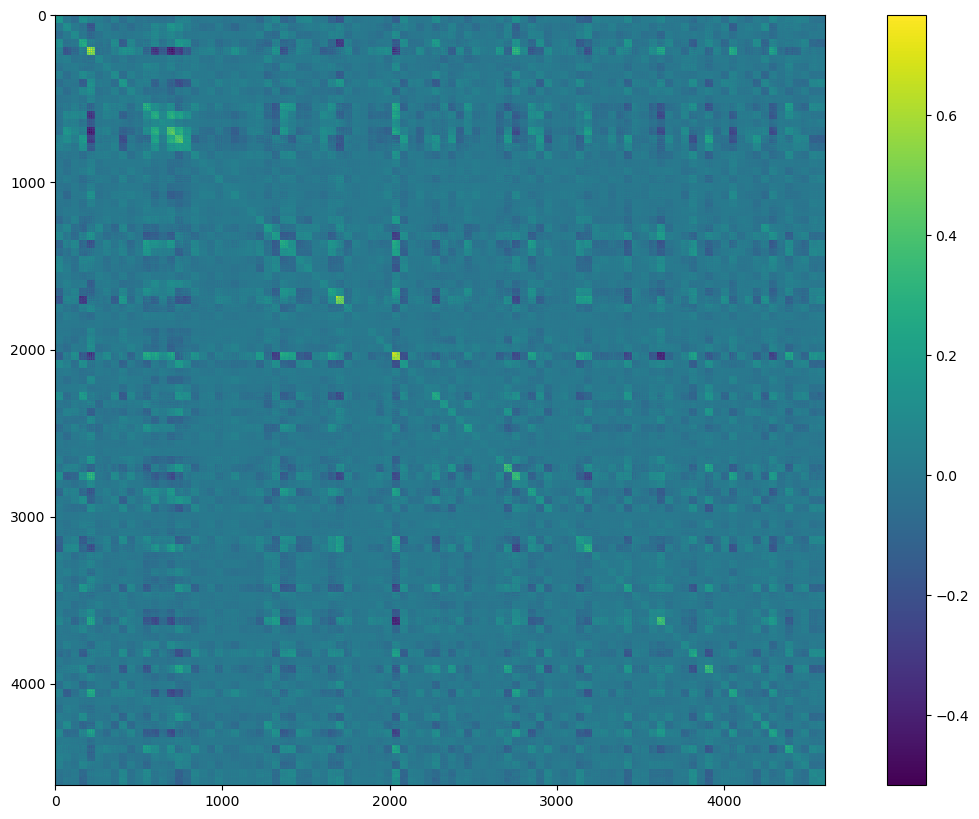

In [12]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
fim = ax.imshow(output_dict['fim_list'][0].fim['features.0.0.weight'].cpu().numpy(), interpolation='nearest')
fig.colorbar(fim, orientation='vertical')

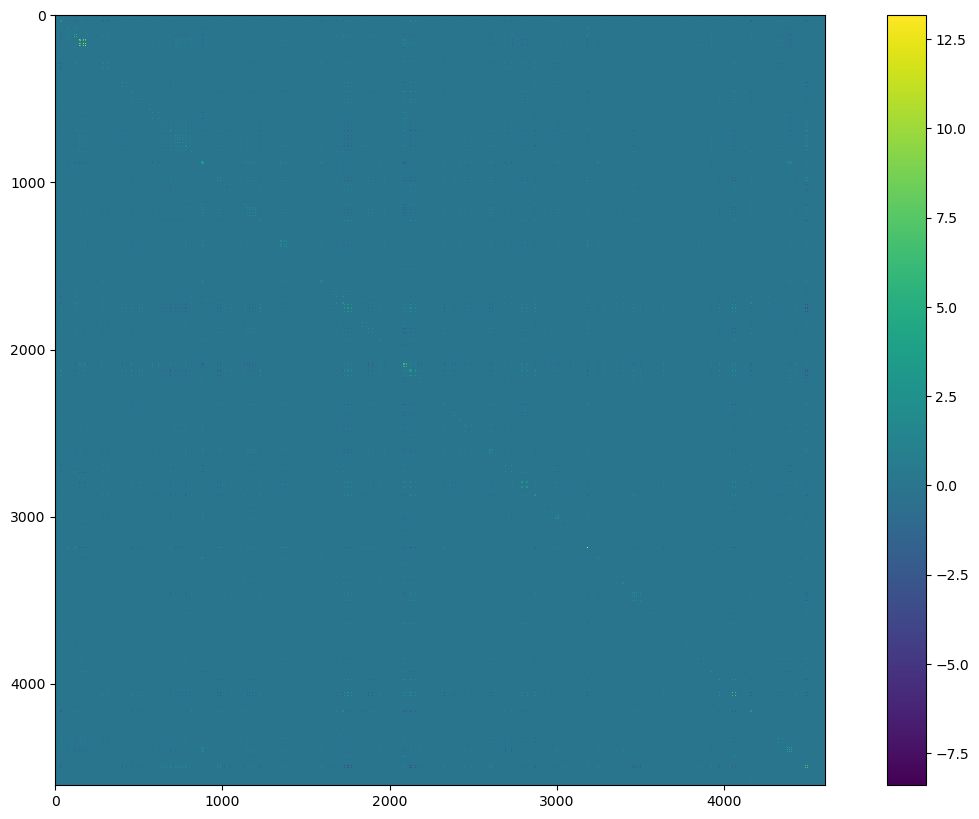

In [14]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
fim = ax.imshow(output_dict['fim_list'][-2].fim['features.0.0.weight'].cpu().numpy(), interpolation='nearest')
fig.colorbar(fim, orientation='vertical')